In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
import pyreadr

from utils import helpers

from importlib import reload

In [3]:
hits_data = pyreadr.read_r('hit_data.rds')[None]

outfield_dims = pyreadr.read_r('fences.rds')[None]

# From Geom

dims = pd.read_csv('https://raw.githubusercontent.com/bdilday/GeomMLBStadiums/master/inst/extdata/mlb_stadia_paths.csv')

In [4]:
# Get Correct Spray Angles

outfield_dims['spray_angle'] = outfield_dims.apply(lambda x: helpers.spray_angle(x.x, x.y),1) 

hits_data['spray_angle_true'] = hits_data.apply(lambda x: helpers.spray_angle(x.hc_x_, x.hc_y_),1)

In [5]:
outfield_dims['team_abv'] = outfield_dims['team'].apply(lambda x: helpers.mapping[x])

In [6]:
def closest_point(row):
    """Finds the index of the closest point in a list of nodes to a given node.

    Args:
        node (numpy.ndarray): The coordinates of the reference node.
        nodes (list): A list of nodes represented as numpy arrays.

    Returns:
        int: The index of the closest node in the list.
    """
    node = np.asarray([row[0],row[1]])
    
    nodes = np.asarray(outfield_dims.query(f'team_abv == "{row[2]}"')[['x','y']])
    dist_2 = np.sum((nodes - node) ** 2, axis=1)

    return np.argmin(dist_2)

def get_height_at_closest_point(row):
    return outfield_dims.query(f'team_abv == "{row[1]}"').iloc[row[0],:]['fence_height']

hits_data['closest_point'] = hits_data[['hc_x_','hc_y_','home_team']].apply(lambda row: closest_point(row),1)

hits_data['fence_height'] = hits_data[['closest_point','home_team']].apply(lambda row: get_height_at_closest_point(row),axis=1)

In [11]:
# For each ball hit, use the spline to interpolate the exact distance and height needed for a homerun at the designated park

def home_run_needed_metrics(spray_angle, team):
    temp = outfield_dims.query(f'team_abv == "{team}"').sort_values('spray_angle')

    dist_func = make_interp_spline(temp['spray_angle'], temp['d_wall'])
    height_func = make_interp_spline(temp['spray_angle'], temp['fence_height'],k=1)

    dist = dist_func(spray_angle)
    height = height_func(spray_angle)

    return dist, height


# Use physics to determine the height at the estimated distance. First step is if estimated dist >= dist at spray angle, next is if physics height 
# is >= height at spray angle

def is_home_run(hit_distance, launch_angle, hit_height, spray_angle, team):

    wall_distance, fence_height = home_run_needed_metrics(spray_angle, team)

    #Calculating V: initial velocity using estimated hit distance and launch angle
    velocity = np.sqrt(hit_distance/((np.sin(2*launch_angle*np.pi/180))/32.174))

    #Vox: Initial horizontal velocity using initial velocity and launch angle
    vox = np.cos(launch_angle/180*np.pi)*velocity

    #Voy: Initial vertical velocity using initial velocity and launch angle
    voy = np.sin(launch_angle/180*np.pi)* velocity

    #Time it takes to reach distance of mega field dimension
    time = wall_distance/vox

    #Calculating vertical height at distance of mega wall
    height_at_time = hit_height+(voy*time)+0.5*(-32.174)*(time**2)

    if height_at_time > fence_height:
        return 1
    return 0

# Analysis

# Testing

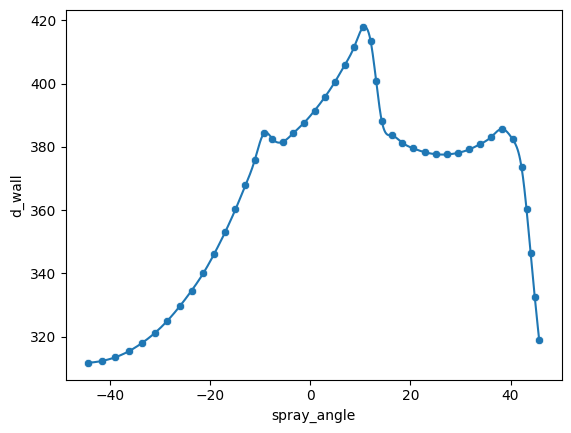

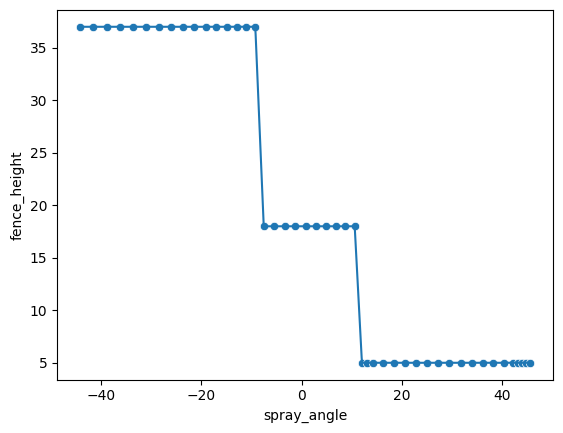

In [10]:
from scipy.interpolate import make_interp_spline

temp = outfield_dims.query('team_abv == "BOS"').sort_values('spray_angle')

x_hat = np.linspace(temp['spray_angle'].min(), temp['spray_angle'].max(),1000)

dist_func = make_interp_spline(temp['spray_angle'], temp['d_wall'])
height_func = make_interp_spline(temp['spray_angle'], temp['fence_height'],k=1)

sns.scatterplot(temp, x='spray_angle',y='d_wall')
plt.plot(x_hat, dist_func(x_hat))
plt.show()

sns.scatterplot(temp, x='spray_angle',y='fence_height')
plt.plot(x_hat, height_func(x_hat))
plt.show()

In [380]:
height_func(-23)

array(8.)

In [322]:
outfield_dims.query('team_abv == "SF"').iloc[8,:]['fence_height']

25.0

In [317]:
hits_data.query('events == "Home Run"')[['home_team','hc_x_','hc_y_','closest_point']]

,home_team,hc_x_,hc_y_,closest_point
2,BOS,-99.801883,403.150693,31
3,SF,209.661321,343.179719,8
18,BAL,-132.944394,405.346884,30
29,CHC,-112.754416,395.189503,29
31,LAD,-32.019459,317.524221,24
...,...,...,...,...
15807,HOU,226.407273,323.414005,5
15827,HOU,191.742403,320.444156,6
15842,BAL,11.430173,458.280066,22
15844,MIA,-81.508615,407.068897,28


In [306]:
hits_data['closest_point']

0        31
1         1
2        31
3         8
4         8
         ..
15848    32
15849    24
15850    15
15851    16
15852    32
Name: closest_point, Length: 15853, dtype: int64

In [207]:
helpers.closest_point([238,279],outfield_dims.query('team == "cubs"')[['x','y']])

AttributeError: module 'utils.helpers' has no attribute 'closest_point'

In [190]:
outfield_dims.query('team == "cubs"').iloc[3,:][['d_wall','spray_angle']]

d_wall         362.102198
spray_angle      39.80139
Name: 301, dtype: object

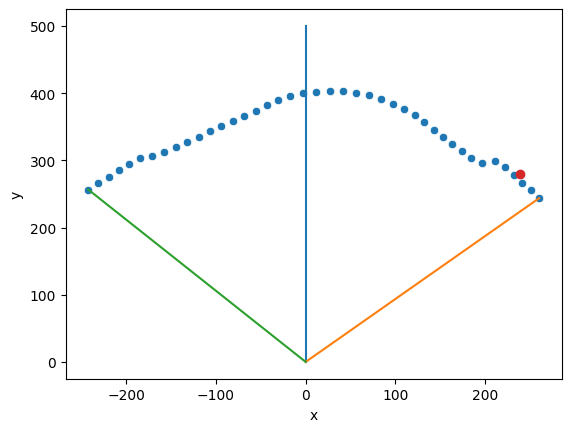

In [192]:
sns.scatterplot(data=outfield_dims.query('team == "cubs"'), x='x',y='y')
plt.plot([0,0],[0,500])
plt.plot([0,260.048918],[0,243.652360])
plt.plot([0,-242.274875	],[0,256.544719])
plt.plot(238.7,279.14,'o')

In [193]:
math.dist([0,0],[238.7,279.14])

367.2830374520446

In [156]:
hits_data['home_team'].unique()

array(['CHC', 'BOS', 'SF', 'SEA', 'HOU', 'KC', 'BAL', 'CIN', 'MIA', 'PHI',
       'CLE', 'MIN', 'MIL', 'NYM', 'LAD', 'STL', 'DET', 'WSH', 'CWS',
       'TOR', 'ATL', 'ARI', 'COL', 'TB', 'NYY', 'OAK', 'LAA', 'PIT', 'SD',
       'TEX'], dtype=object)

In [175]:
hits_data['spray_angle_true'] = hits_data.apply(lambda x: helpers.spray_angle(x.hc_x_, x.hc_y_),1)

In [194]:
hits_data.columns

Index(['player_name', 'game_date', 'game_type', 'player_team', 'events', 'des',
       'home_team', 'away_team', 'bb_type', 'outs_when_up', 'inning',
       'inning_topbot', 'plate_z', 'hc_x', 'hc_y', 'hit_distance_sc',
       'launch_angle', 'launch_speed', 'hc_x_', 'hc_y_', 'launch_angle_rads',
       'launch_speed_fts', 'launch_speed_x', 'launch_speed_y', 'spray_angle',
       'index', 'hit_direction', 'stadium_observed', 'logo_html', 'headshot',
       'spray_angle_true'],
      dtype='object')

In [202]:
hits_data.query('home_team == "CHC"')[['events','inning','hc_x_','hc_y_','hit_distance_sc','launch_angle','launch_speed_fts','launch_speed_x','launch_speed_y','spray_angle_true']]

,events,inning,hc_x_,hc_y_,hit_distance_sc,launch_angle,launch_speed_fts,launch_speed_x,launch_speed_y,spray_angle_true
0,Double,6.0,-104.468788,315.802208,331.0,16.0,154.586667,148.598241,42.609860,-18.304447
17,"In play, out(s)",4.0,153.059502,307.716234,339.0,34.0,140.946667,116.850082,78.816376,26.445968
29,Home Run,4.0,-112.754416,395.189503,408.0,27.0,147.840000,131.726405,67.117955,-15.924367
71,"In play, out(s)",9.0,75.394221,364.168312,368.0,30.0,148.720000,128.795298,74.360000,11.696770
72,Home Run,9.0,-105.691667,397.186040,408.0,29.0,155.906667,136.359043,75.585052,-14.901163
...,...,...,...,...,...,...,...,...,...,...
15750,Triple,3.0,238.735888,279.140801,359.0,25.0,145.346667,131.728816,61.426156,40.538801
15810,Double,2.0,-202.923009,281.636472,343.0,26.0,160.013333,143.819031,70.145228,-35.773276
15819,"In play, out(s)",9.0,66.484675,376.671624,379.0,28.0,152.386667,134.549441,71.541207,10.009929
15828,Double,9.0,-205.643290,293.440996,354.0,24.0,154.880000,141.489920,62.995371,-35.022751


In [125]:
outfield_dims['team'].unique()

array(['angels', 'astros', 'athletics', 'blue_jays', 'braves', 'brewers',
       'cardinals', 'cubs', 'diamondbacks', 'dodgers', 'giants',
       'indians', 'mariners', 'marlins', 'mets', 'nationals', 'orioles',
       'padres', 'phillies', 'pirates', 'rangers', 'rays', 'reds',
       'rockies', 'royals', 'tigers', 'twins', 'white_sox', 'yankees',
       'red_sox'], dtype=object)

In [126]:
outfield_dims.query('team == "cubs" and segment == "outfield_outer"')

,stadium,full_team_name,team,team_abbr,x,y,d_wall,segment,spray_angle_stadia,fence_height,orientation
298,Wrigley Field,Chicago Cubs,cubs,CHC,260.048918,243.652360,356.359246,outfield_outer,35.1,16.0,NE
299,Wrigley Field,Chicago Cubs,cubs,CHC,250.666382,255.195296,357.712558,outfield_outer,33.4,16.0,NE
300,Wrigley Field,Chicago Cubs,cubs,CHC,241.226180,266.691178,359.602912,outfield_outer,31.6,16.0,NE
301,Wrigley Field,Chicago Cubs,cubs,CHC,231.791876,278.191531,362.102198,outfield_outer,29.9,16.0,NE
302,Wrigley Field,Chicago Cubs,cubs,CHC,222.284561,289.630579,365.097656,outfield_outer,28.1,16.0,NE
303,Wrigley Field,Chicago Cubs,cubs,CHC,211.213896,298.557122,365.715278,outfield_outer,26.5,16.0,NE
304,Wrigley Field,Chicago Cubs,cubs,CHC,196.669380,296.084714,355.450423,outfield_outer,25.2,11.0,NE
305,Wrigley Field,Chicago Cubs,cubs,CHC,184.406558,303.466200,355.102116,outfield_outer,23.5,11.0,NE
306,Wrigley Field,Chicago Cubs,cubs,CHC,174.047724,314.139418,359.132544,outfield_outer,21.7,11.0,NE
307,Wrigley Field,Chicago Cubs,cubs,CHC,163.535396,324.662288,363.523626,outfield_outer,20.1,11.0,NE


<AxesSubplot: xlabel='x', ylabel='y'>

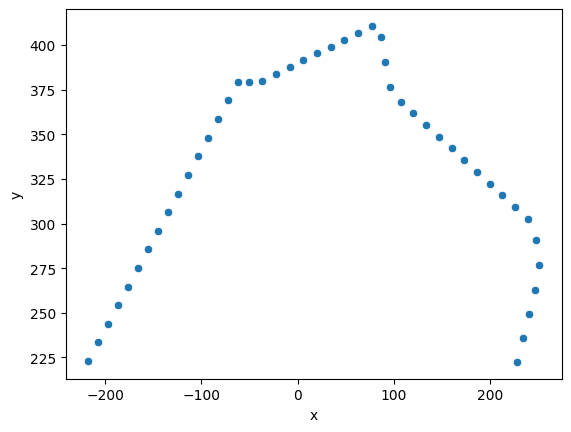

In [74]:
sns.scatterplot(data=outfield_dims.query('team == "red_sox" and segment == "outfield_outer"'), x='x',y='y')

In [69]:
dims.query('team == "angels" and segment == "outfield_outer"')

,team,x,y,segment,spray_angle
3029,angels,26.270000,104.810000,outfield_outer,-64.886743
3030,angels,25.932060,98.807795,outfield_outer,-58.195165
3031,angels,26.551758,92.865560,outfield_outer,-52.101109
3032,angels,29.069971,87.457350,outfield_outer,-46.118702
3033,angels,32.986155,82.913310,outfield_outer,-40.808629
...,...,...,...,...,...
3123,angels,36.234236,132.025786,outfield_outer,-113.153543
3124,angels,32.618710,127.222803,outfield_outer,-104.539903
3125,angels,29.003184,122.419820,outfield_outer,-97.791428
3126,angels,27.310342,116.780127,outfield_outer,-85.231652


In [4]:
hits_data['home_team'].unique()

array(['CHC', 'BOS', 'SF', 'SEA', 'HOU', 'KC', 'BAL', 'CIN', 'MIA', 'PHI',
       'CLE', 'MIN', 'MIL', 'NYM', 'LAD', 'STL', 'DET', 'WSH', 'CWS',
       'TOR', 'ATL', 'ARI', 'COL', 'TB', 'NYY', 'OAK', 'LAA', 'PIT', 'SD',
       'TEX'], dtype=object)

In [5]:
hits_data.query('home_team == "BOS" and events == "Home Run"')['spray_angle'].describe()

count    109.000000
mean      -5.919266
std       20.925425
min      -35.100000
25%      -24.100000
50%      -10.000000
75%       13.100000
max       36.400000
Name: spray_angle, dtype: float64

In [7]:
# Spray Angle conversion

dims['spray_angle'] =  np.tan((dims['x']-128)/(208-dims['y']))*180/np.pi*0.75

c:\Users\noahs\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in tan
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
dims['segment'].unique()

array(['infield_inner', 'infield_outer', 'outfield_outer',
       'outfield_inner', 'foul_lines', 'home_plate'], dtype=object)

In [9]:
dims.query('team == "red_sox" and (segment == "foul_lines" or segment == "foul_lines")')['y'].min()

112.68549910874

In [217]:
dims.query('team == "red_sox" and (segment == "foul_lines")').max()

team              red_sox
x              214.746905
y                  204.53
segment        foul_lines
spray_angle       57.6048
dtype: object

In [46]:
red_sox = dims.query('team == "red_sox" and (segment == "foul_lines" or segment == "outfield_outer")')

In [27]:
def find_peak(df):
    y_point = float(df['y'].max())
    x_point = float(df[df['y']==y_point]['x'])

    return x_point, y_point

In [53]:
def get_team_foul_lines(df, team):
    foul_lines_df = df.query(f"team == '{team}' & segment == 'foul_lines'")
    return foul_lines_df

def get_team_outfield(df, team):
    outfield_df = df.query(f"team == '{team}' & segment == 'outfield_outer'")
    return outfield_df

def get_only_outfield(df, team):
    foul_lines_df = get_team_foul_lines(df, team)
    outfield_df = get_team_outfield(df, team)

    only_outfield_df = outfield_df[outfield_df['y']<=foul_lines_df['y'].min()]

    return only_outfield_df

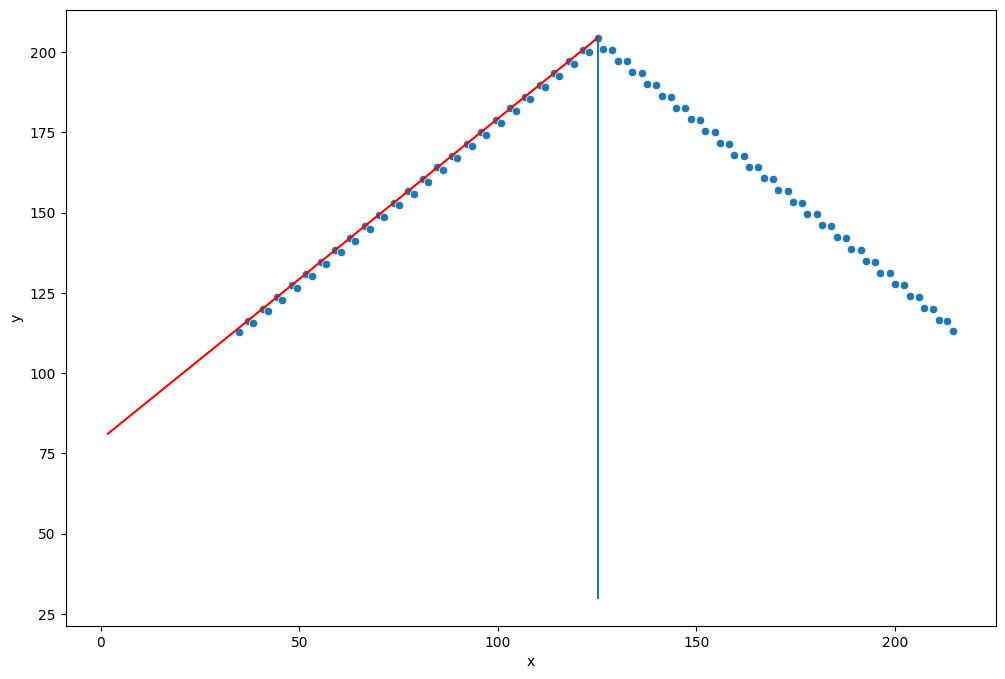

In [49]:
foul_lines_df = get_team_foul_lines(dims, "red_sox")

peak_x, peak_y = find_peak(foul_lines_df)

x = np.array([peak_x] * 1000)
y = np.linspace(30,peak_y, 1000)

d = np.deg2rad(-45)

x1 = (x - peak_x)*np.cos(d) - (y - peak_y)*np.sin(d) + peak_x
y1 = (x - peak_x)*np.sin(d) + (y - peak_y)*np.cos(d) + peak_y

plt.figure(figsize=(12,8))

sns.scatterplot(data=foul_lines_df, x='x',y='y')
plt.plot(x,y)
plt.plot(x1,y1,'r')

In [61]:
dims['team'].unique()

array(['angels', 'astros', 'athletics', 'blue_jays', 'braves', 'brewers',
       'cardinals', 'cubs', 'diamondbacks', 'dodgers', 'giants',
       'indians', 'mariners', 'marlins', 'mets', 'nationals', 'orioles',
       'padres', 'phillies', 'pirates', 'rangers', 'rays', 'red_sox',
       'reds', 'rockies', 'royals', 'tigers', 'twins', 'white_sox',
       'yankees', 'generic'], dtype=object)

C:\Users\noahs\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot: xlabel='x', ylabel='y'>

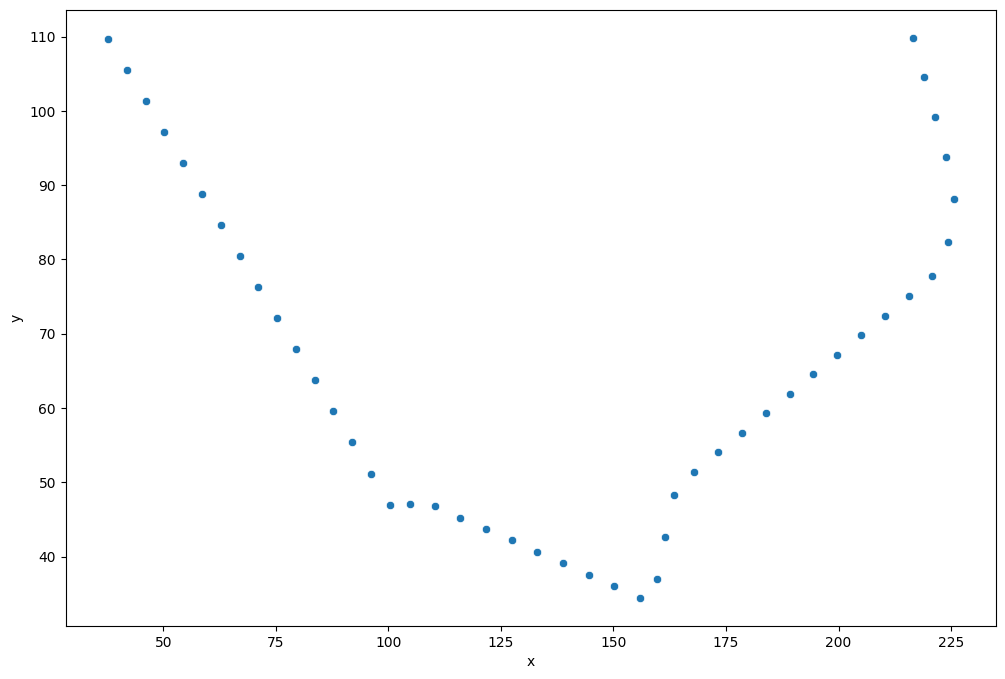

In [72]:
only_outfield_df = get_only_outfield(dims, "red_sox")

x_hat = np.linspace(only_outfield_df['x'].min(), only_outfield_df['x'].max(), 1000)

plt.figure(figsize=(12,8))

# my_pwlf = pwlf.PiecewiseLinFit(only_outfield_df['x'], only_outfield_df['y'])
# breaks = my_pwlf.fit(6)

# y_hat = my_pwlf.predict(x_hat)

model = np.polyfit(only_outfield_df['x'], only_outfield_df['y'], 20)
func = np.poly1d(model)

y_hat = func(x_hat)

sns.scatterplot(data=only_outfield_df, x='x',y='y')
#plt.plot(x_hat, y_hat,'r')

In [ ]:
df['spray_angle'] = np.tan((df['hc_x']-128)/(208-df['hc_y']))*180/np.pi*0.75

In [118]:
dist = np.polyfit(df['spray_angle_stadia'], df['d_wall'], 20)
f_dist = np.poly1d(dist)

height = np.polyfit(df['spray_angle_stadia'], df['fence_height'], 20)
f_height = np.poly1d(height)

x1 = np.linspace(min(df['spray_angle_stadia']), max(df['spray_angle_stadia']), 1000)
y1 = f_dist(x1)
y2 = f_height(x1)

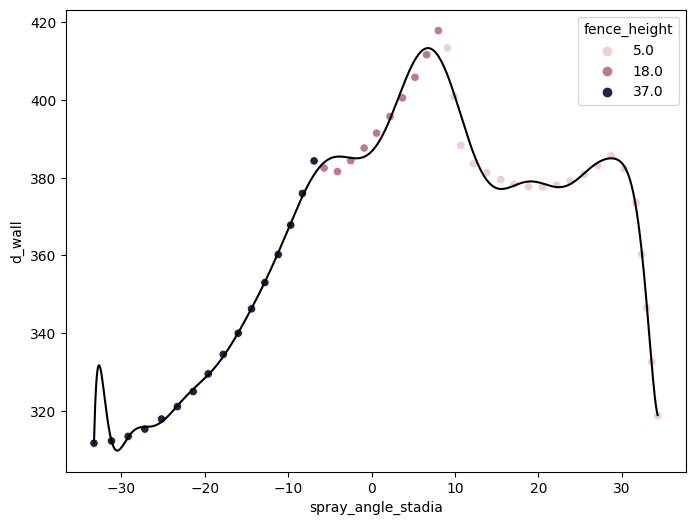

In [119]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=df, x='spray_angle_stadia',y='d_wall',hue='fence_height')

plt.plot(x1, y1, c='black')

In [106]:
from scipy import optimize

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(0, 15, 100)
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p))

NameError: name 'x' is not defined

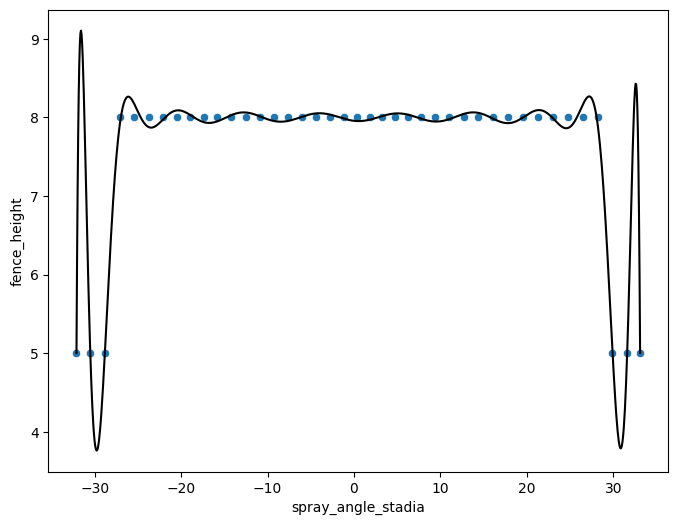

In [105]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=angels, x='spray_angle_stadia',y='fence_height')

plt.plot(x1, y2, c='black')

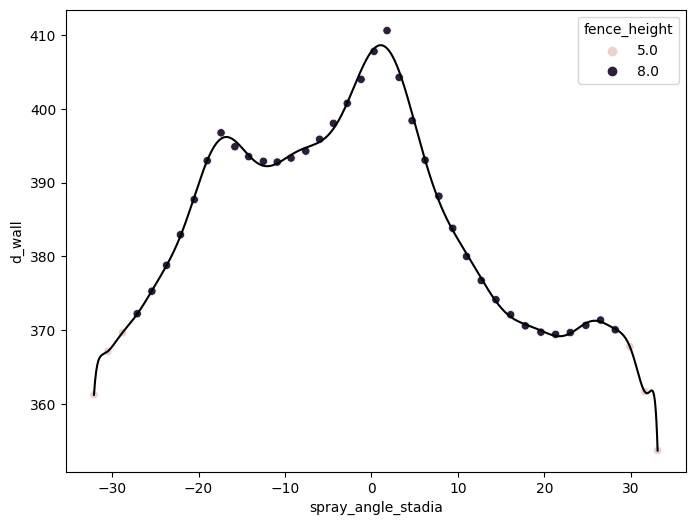

In [74]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=angels, x='spray_angle_stadia',y='d_wall',hue='fence_height')

plt.plot(x1, y1, c='black')

<AxesSubplot: xlabel='spray_angle_stadia', ylabel='d_wall'>

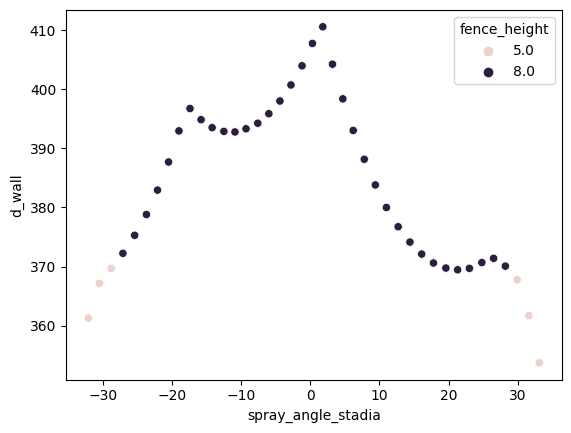

In [38]:
sns.scatterplot(data=angels,x='spray_angle_stadia',y='d_wall',hue='fence_height')

<AxesSubplot: xlabel='x', ylabel='y'>

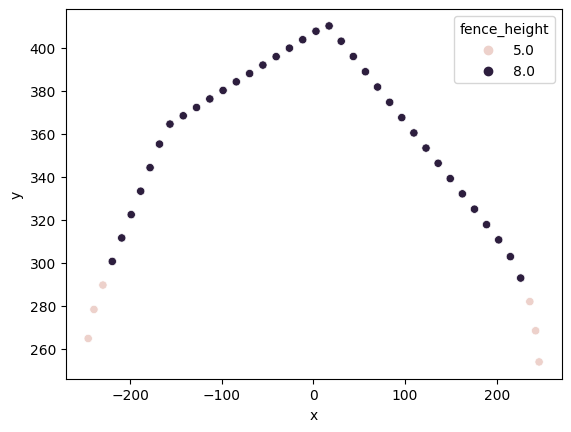

In [31]:
sns.scatterplot(data=angels,x='x',y='y',hue='fence_height')

In [36]:
def parametric_curve(x1, y1, x2, y2):
    xslope = x2 - x1
    yslope = y2 - y1
    tt = np.linspace(0, 1, num=100)
    ll = [pd.DataFrame({"x": x1 + xslope * s, "y": y1 + yslope * s}) for s in tt]
    return pd.concat(ll)

def geom_curve_gen_points(x1, x2, y, curvature):
    if x2 < x1:
        tmp = x1
        x1 = x2
        x2 = tmp
    
    k = curvature
    xscale = 0.5 * (x2 - x1)

    d1 = (1 - k**2) / (2 * k)
    r = d1 + k

    starting_theta = abs(np.arctan2(1, d1))
    tt = np.linspace(-starting_theta, starting_theta, num=100)
    x0 = 0.5 * (x1 + x2)
    y0 = y + d1 * xscale
    r = r * xscale
    xx = x0 + r * np.sin(tt)
    yy = y0 - r * np.cos(tt)
    return pd.DataFrame({"t": tt, "x": xx, "y": yy})



def generate_sample_data():
    np.random.seed(101)
    batted_ball_data = pd.DataFrame(
        {"hc_x": np.random.normal(125, 10, 20), "hc_y": np.random.normal(100, 20, 20)}
    )
    batted_ball_data["team"] = np.repeat(["angels", "yankees"], 10)
    return batted_ball_data


def generic_ballpark():
    left_outfield_line = parametric_curve(125, 208, 30, 100)
    outfield_curve = geom_curve_gen_points(30, 220, 100, 0.9)[:, ["x", "y"]]
    right_outfield_line = parametric_curve(220, 100, 125, 208)

    left_infield_line = parametric_curve(125, 208, 80, 155)
    infield_curve = geom_curve_gen_points(80, 170, 155, 0.9)[:, ["x", "y"]]
    right_infield_line = parametric_curve(170, 155, 125, 208)

    outfield_path = pd.concat(
        [left_outfield_line, outfield_curve, right_outfield_line], axis=0
    )
    outfield_path["segment"] = "outfield_outer"
    infield_path = pd.concat(
        [left_infield_line, infield_curve, right_infield_line], axis=0
    )
    infield_path["segment"] = "infield_outer"

    path_df = pd.concat([outfield_path, infield_path], axis=0)
    team_df = pd.DataFrame({"team": ["generic"] * len(path_df)})
    return pd.concat([team_df, path_df], axis=1)

